In [1]:
from kaggle.api.kaggle_api_extended import KaggleApi
import os

# Authenticate Kaggle API
api = KaggleApi()
api.authenticate()

# Correct dataset name
dataset_name = 'ahmedhamada0/brain-tumor-detection'  # Replace with actual dataset name

# Define the download path (use raw string for Windows path)
download_path = r"D:\Deep_Learning\Brain_Tumor_Detection"

# Create the folder if it doesn’t exist
os.makedirs(download_path, exist_ok=True)

# Download and unzip the dataset
api.dataset_download_files(dataset_name, path=download_path, unzip=True)

print(f"Dataset downloaded successfully to: {download_path}")

Dataset URL: https://www.kaggle.com/datasets/ahmedhamada0/brain-tumor-detection
Dataset downloaded successfully to: D:\Deep_Learning\Brain_Tumor_Detection


In [50]:
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical


# Define the dataset
tumor_pos = []
tumor_neg = []

# Load tumor positive images (label 1)
for file in glob.iglob(r'D:\Deep_Learning\Brain_Tumor_Detection\yes\*'):
    img = cv2.imread(file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    img = cv2.resize(img, (224, 224))           # Resize to 224x224
    tumor_pos.append((img, 1))                  # Label 1 for tumor

# Load tumor negative images (label 0)
for file in glob.iglob(r'D:\Deep_Learning\Brain_Tumor_Detection\no\*'):
    img = cv2.imread(file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    tumor_neg.append((img, 0))                  # Label 0 for no tumor

# Combine data
data = tumor_pos + tumor_neg      

# Extract images and labels
x = np.array([i[0] for i in data])  # Images
y = np.array([i[1] for i in data])  # Labels


In [51]:
print(x.shape,y.shape)  

(3000, 224, 224, 3) (3000,)


In [52]:
from sklearn.model_selection import train_test_split

#splitting the data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.20, random_state=42)


In [53]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((2400, 224, 224, 3), (2400,), (600, 224, 224, 3), (600,))

In [54]:
# Normalize the data (0 to 1)
x_train = x_train/255.0
x_test = x_test/255.0

In [55]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((2400, 224, 224, 3), (2400,), (600, 224, 224, 3), (600,))

In [56]:
# Convert labels to one-hot encoding for categorical_crossentropy
y_train = to_categorical(y_train, num_classes=2)  # [0] -> [1, 0], [1] -> [0, 1]
y_test = to_categorical(y_test, num_classes=2)

In [57]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((2400, 224, 224, 3), (2400, 2), (600, 224, 224, 3), (600, 2))

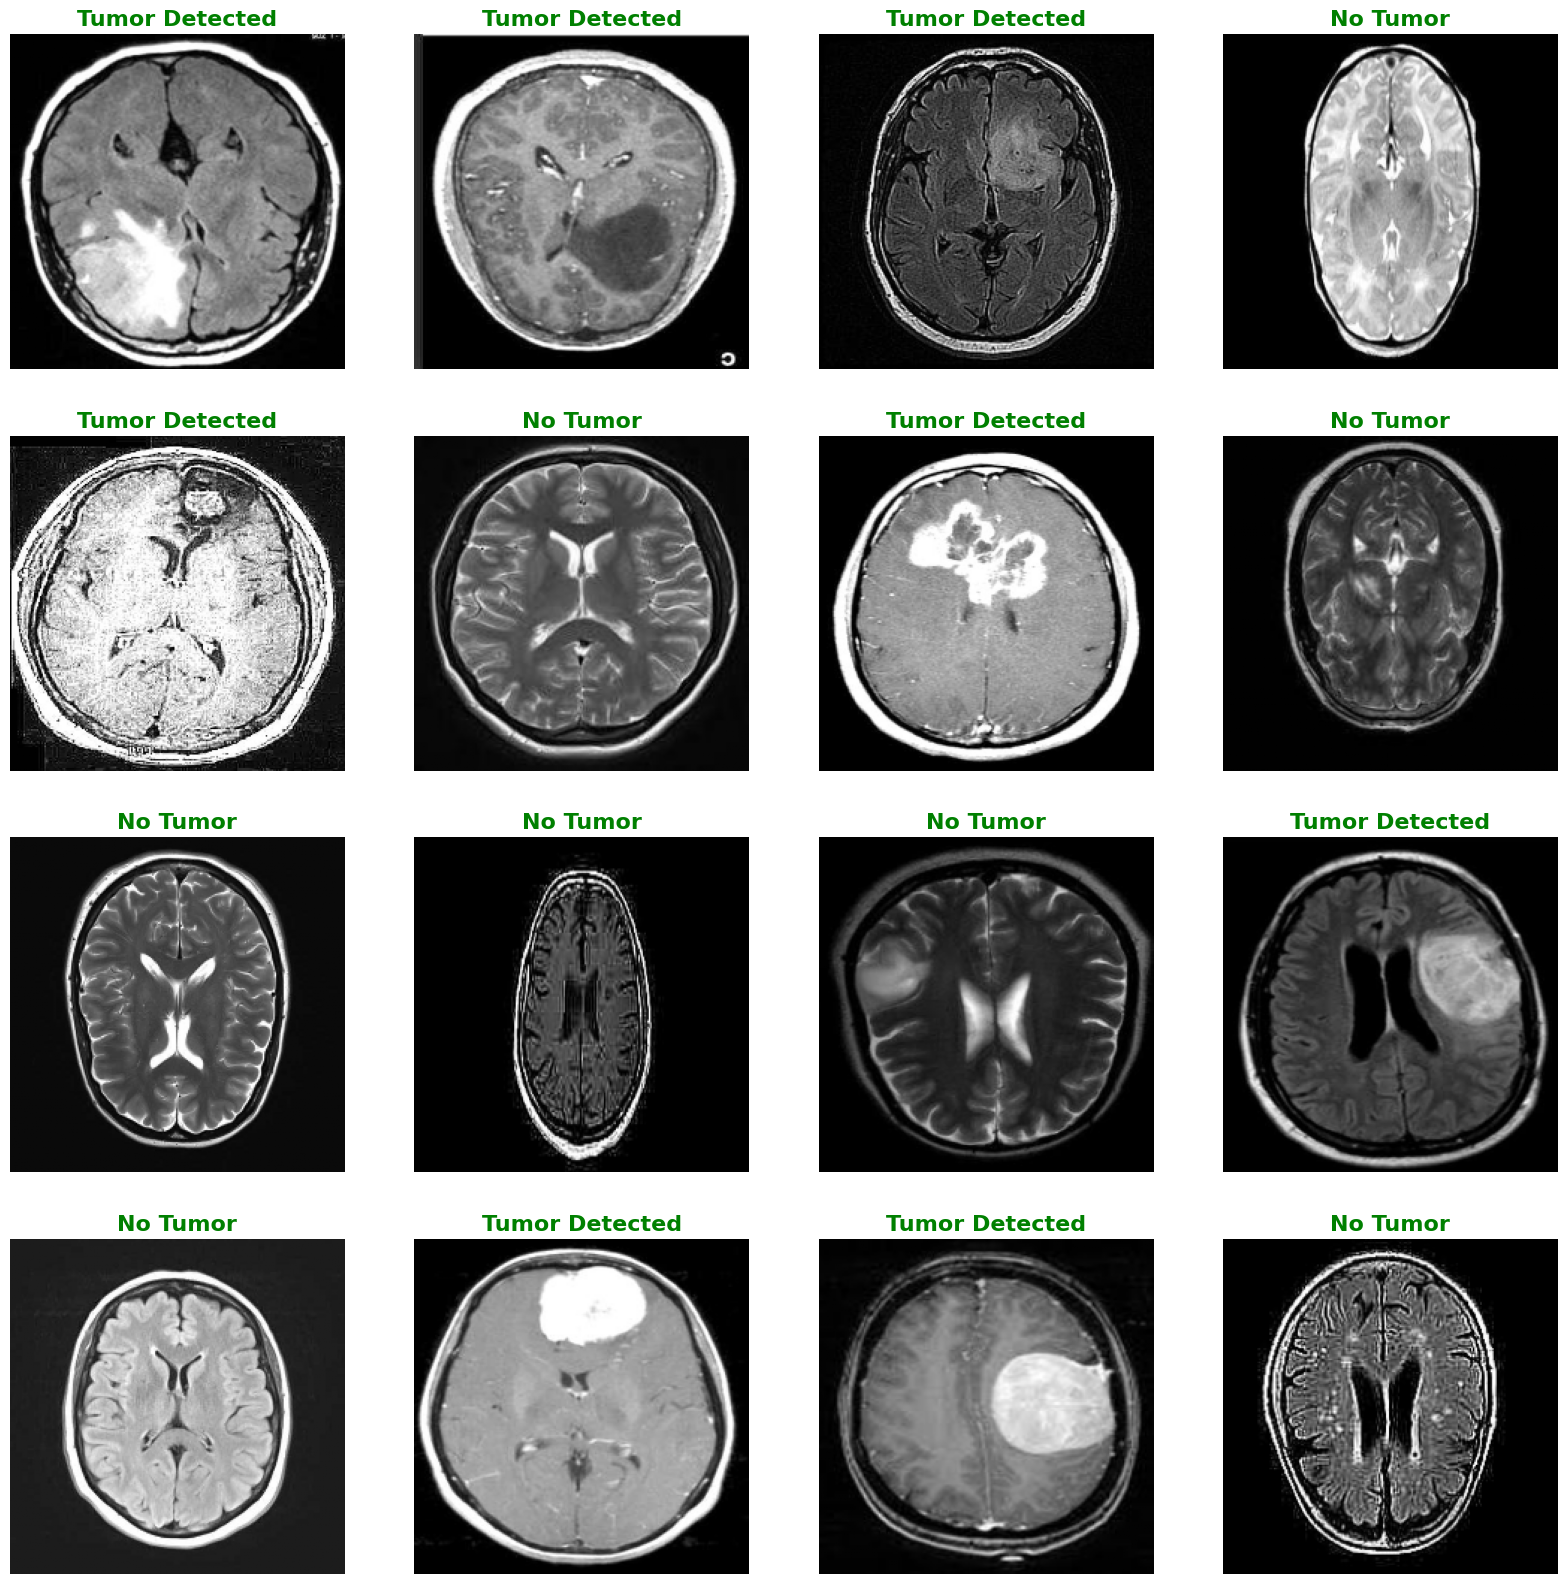

In [58]:
import matplotlib.pyplot as plt
import numpy as np

# Class labels
class_names = ["No Tumor", "Tumor Detected"]

# Plot the first 16 images from the training set
plt.figure(figsize=(20, 20))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(x_train[i])
    
    # Get the class label
    label_index = np.argmax(y_train[i])  # Convert one-hot to class index
    plt.title(class_names[label_index], color='green', fontsize=16, fontweight='bold')
    
    plt.axis("off")
plt.show()


In [60]:
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping

# Define the CNN model
model = models.Sequential([
    # Layer 1: Extracts low-level features (edges, textures) from 224x224 RGB images.
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    # Reduces spatial dimensions, decreasing computation and making features more robust.
    layers.MaxPooling2D((2, 2)),

    # Layer 2: Learns more complex features by combining previous features.
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Layer 3: Captures higher-level patterns relevant for tumor detection.
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Layer 4: Captures even higher level features.
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Layer 5: Captures very high level features.
    layers.Conv2D(512, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    # Flatten: Converts the 3D feature maps to a 1D vector for classification.
    layers.Flatten(),

    # Dropout: Regularization technique to prevent overfitting by randomly dropping neurons.
    layers.Dropout(0.3),

    # Dense layer: Fully connected layer for feature combination and classification.
    layers.Dense(512, activation='relu'),

    # Output layer: Uses sigmoid for binary classification (tumor/no tumor).
    layers.Dense(2, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',  # Adam optimizer for efficient training.
              loss='binary_crossentropy',  # Loss function for binary classification.
              metrics=['accuracy'])  # Monitors accuracy during training.
model.summary()  # Displays the model's architecture, layer shapes, and parameters.

# Early stopping callback to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = model.fit(x_train, y_train,  # Training data.
                    epochs=10,  # Number of training epochs.
                    validation_data=(x_test, y_test), # Validation data to monitor performance.
                    batch_size=32, # Number of samples per gradient update.
                    callbacks=[early_stopping])  # Apply early stopping during training.

# Evaluate the model
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)  # Evaluates the model on test set.
print(f"Test Accuracy: {accuracy:.2f}")  # Prints the test accuracy.
print(f"Test Loss: {loss:.2f}")  # Prints the test loss.

# Save the model (optional)
model.save('brain_tumor_cnn.h5')
print("Model saved as 'brain_tumor_cnn.h5'")


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_22 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 111, 111, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_23 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 54, 54, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_24 (Conv2D)          (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 26, 26, 128)     

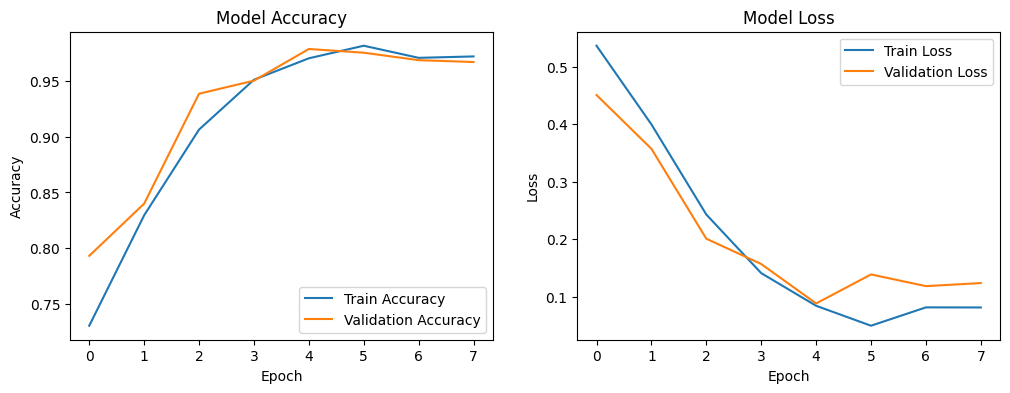

In [62]:
# Plot results
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [61]:
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model('brain_tumor_cnn.h5')

# Predict on a new image
def predict_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    img = img / 255.0  # Normalize
    img = np.expand_dims(img, axis=0)  # Add batch dimension

    prediction = model.predict(img)
    return "Tumor Detected" if np.argmax(prediction) == 1 else "No Tumor"

# Example usage
result = predict_image(r"D:\Deep_Learning\Brain_Tumor_Detection\no\no0.jpg")
print(result) 


1/1 [==============================] - 0s 138ms/step
No Tumor
